# IDS Bayesian Interferometry

In [1]:
import pymc3 as pm
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
control = 0 # 0: sinthetic; 1: real
mycmap = 'inferno'
np.random.seed(100)

In [3]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs, cmap=mycmap)
    plt.grid('off')
    
    if save:
        plt.savefig(name, format= 'png')

In [4]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp((a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) -2*np.pi*1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]])
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-1./2*xx.T.dot(invSigma).dot(xx))


## Creating artificial data

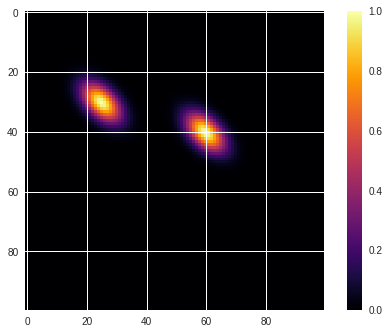

In [35]:
if control:
    path = '/home/lerko/Dataset_ALMA'
    fileName = 'Dataset_ALMA_11_07_17.mat'
    fullPath = path +'/' + fileName
    data = sio.loadmat(fullPath)
    
    img = data['Dataset']['name_3c286'][0,0]['size_128x128'][0,0]
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape
    print(data['Dataset'].dtype)
elif not control:
    x = np.arange(100)
    y = np.arange(100)
    
    s1 = np.array([20,20])
    s2 = np.array([20,20])
    s12 = np.array([10,10])

    a = -1./2*s2/(s1*s2-s12**2)
    b = -1./2*s1/(s1*s2-s12**2)
    c = s12/(s1*s2-s12**2)
#     invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
#     print(np.linalg.inv(invSigma))

    e = np.array([30,40])
    f = np.array([25,60])
    numberOfBasis = e.shape[0]
    img = np.zeros((x.shape[0],y.shape[0]))

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            for k in range(numberOfBasis):
                img[i,j] = img[i,j] + psi(x[i],y[j],a[k],b[k],c[k],e[k],f[k])
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape

plt.imshow(img, cmap=mycmap)
plt.colorbar()

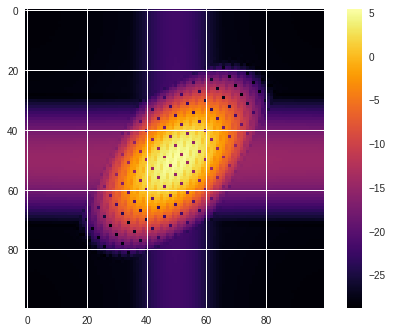

In [36]:
# Calculate the spectrum
img_fft= np.fft.fft2(img)
FTgshift = np.fft.fftshift(img_fft)

plt.imshow(np.log(np.abs(FTgshift)), cmap=mycmap)
plt.colorbar()

## Creating sampling mask


For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

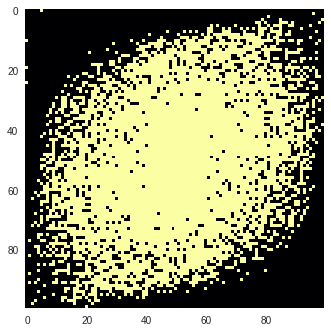

In [37]:
from masking import *

## Parameters
B_max = 1
antennas = 120
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable `measurements` are the 2D representation for the measurements. `U` are the positions in the `u,v` spaces, i.e., `U[0] = u`, `U[1] = v`. Finally, `V` is the visibility function.

Percentage of measurements: 53.56


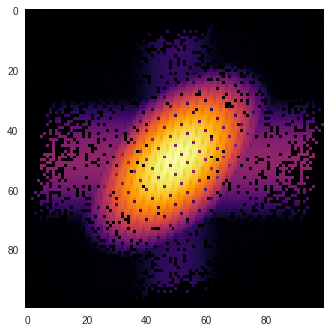

In [38]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs)

p = 100*U.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % p)

## RBF Model
### Priors and Model

$$
V_{obs}(u,v) = \sum_{i=0}^{N_{b}-1}\alpha_i\phi_i(u,v)
$$

donde $\alpha_i \in \mathbb{R}$ y:

$$\phi_i(u,v) = \left[\begin{array}{c}
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \cos \big\lbrace C_x^iu+C_y^iv\big\rbrace \\
    \exp\big\lbrace\frac{-2\pi^2(u^2+v^2)}{1/l^2} \big\rbrace \sin \big\lbrace C_x^iu+C_y^iv\big\rbrace
\end{array}\right]$$


$$
\phi_i(u,v) = 2 \pi \sigma^2 \exp \left(-2 \pi\left(j C_x^i u+jC_y^i v+\pi  \sigma^2\left(u^2+v^2\right)\right)\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 u-C_x^i \right),e^{-2 \pi^2 \sigma^2}\right) \vartheta _3\left(\pi  \left(2 j \pi  \sigma^2 v-C_y^i\right),e^{-2 \pi^2 \sigma^2}\right)
$$


where:

$$
\vartheta_3 (q,z) = 1 + 2\sum_{n = 1}^{\infty} q^{n^2}\cos(2nz)
$$

In [39]:
import theano.tensor as tt

def tt_phi(U,a,b,c,e,f):
    u = U[:,0,np.newaxis]
    v = U[:,1,np.newaxis]
    
    A = tt.exp(2.0*np.pi**2*(tt.dot(a,tt.pow(v,2).T) + tt.dot(b,tt.pow(u,2).T) - tt.dot(c,(u*v).T))/(4.*a*b-tt.pow(c,2.0)))
    sinPart = tt.sin(-2*np.pi*(tt.dot(f,v.T)+tt.dot(e,u.T)))
    cosPart = tt.cos(-2*np.pi*(tt.dot(f,v.T)+tt.dot(e,u.T)))
    return A*cosPart, A*sinPart

def visibility_model(U,alpha,a,b,c,e,f, factor = None, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y):
    Uaux = U.astype(float)
    Uaux[:,0] = Uaux[:,0]/(IMAGE_SIZE_Y)
    Uaux[:,1] = Uaux[:,1]/(IMAGE_SIZE_X)
    realPart, imagPart = tt_phi(Uaux,a,b,c,e,f)
    
    return (alpha[:,np.newaxis]*realPart).sum(axis=0) , (alpha[:,np.newaxis]*imagPart).sum(axis=0)

In [40]:
def matrix_points(U,V_real, V_imag, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_X):
#     print(U.shape[0])
#     print(V_real.shape[0])
#     print(V_imag.shape[0])
    U = U.astype(int)
    out_real = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    out_imag = np.zeros([IMAGE_SIZE_X, IMAGE_SIZE_Y])
    for i in range(U.shape[0]):
        out_real[U[i,0],U[i,1]] = V_real[i]
        out_imag[U[i,0],U[i,1]] = V_imag[i]
        
    return out_real, out_imag

[  2.00000000e+000  -7.93204218e-001  -6.38523445e-001 ...,
   1.25090190e-247  -1.49776720e-250   4.25275994e-254]
(0.999378260697-0.00031843893931j)


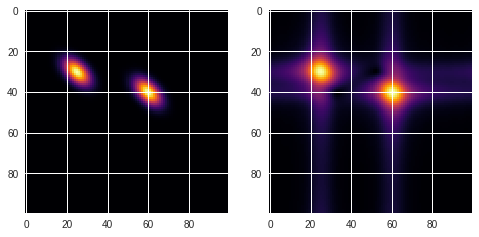

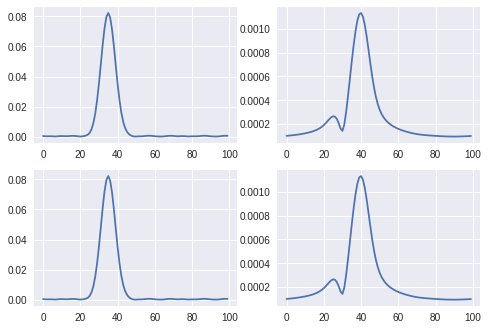

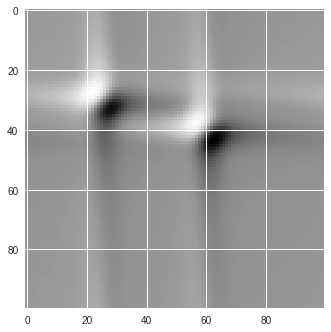

In [41]:
if control == 0:
    numberOfSamplings = U.shape[0]
    numberOfBasis = e.shape[0]

    init_s1 = s1
    init_s2 = s2
    init_s12 = s12
    init_alpha = np.array([1])
    init_e = e[:,np.newaxis]
    init_f = f[:,np.newaxis]
    init_a = a[:,np.newaxis]
    init_b = b[:,np.newaxis]
    init_c = c[:,np.newaxis]
    # print(init_C.shape)
    init_U = U.astype(int)

    u1 = np.arange((100))
    v1 = np.arange((100))

    myU = np.zeros((u1.shape[0]*v1.shape[0],2), dtype=np.int)
    k = 0
    for i in range(u1.shape[0]):
        for j in range(v1.shape[0]):
            myU[k,0] = u1[i]
            myU[k,1] = v1[j]
            k += 1
    
    PHI_Re, PHI_Im = visibility_model(init_U,init_alpha,init_a,init_b,init_c,init_e,init_f,
                                   IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y= IMAGE_SIZE_Y)
    
    print(PHI_Re.eval())
    Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1])
    Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
    Im_pix = np.fft.ifft2(Im_pix_fft)
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(8)
    ax[0].imshow( np.abs(Im_pix) , cmap = mycmap)
    print(np.max(Im_pix))

    Im_ind_real, Im_ind_imag = matrix_points(init_U,PHI_Re.eval(), PHI_Im.eval(), IMAGE_SIZE_X=IMAGE_SIZE_X ,IMAGE_SIZE_Y=IMAGE_SIZE_Y)

    #Im_ind_real = ndimage.rotate(Im_ind_real, 90*2)
    #Im_ind_imag = ndimage.rotate(Im_ind_imag, 90*2)
    # Im_ind = np.log(np.sqrt(Im_ind_real*Im_ind_real+Im_ind_imag*Im_ind_imag) +1e-12)
    Im_ind_fft = Im_ind_real + 1j*Im_ind_imag
    # print(Im_ind_fft.shape)
    Im_ind = np.fft.ifft2(Im_ind_fft)
    #Im_ind = np.fft.fftshift(Im_ind)
    ax[1].imshow( np.abs(Im_ind) , cmap = mycmap)
    # print(np.max(Im_ind))

    fig, ax = plt.subplots(2,2)
    ax[0,0].plot(np.abs(Im_pix[:,50]))
    ax[0,1].plot(np.abs(Im_ind[:,50]))
    ax[1,0].plot(np.abs(Im_pix[:,50]))
    ax[1,1].plot(np.abs(Im_ind[:,50]))

    fig = plt.figure()
    plt.imshow(Im_ind.real)
    plt.imshow(Im_ind.imag)

In [45]:
#from scipy import optimize
numberOfSamplings = U.shape[0]
numberOfBasis = 10
rbf_model = pm.Model()

s1_sd = 50
s2_sd = 50
s12_sd = 50

init_e = IMAGE_SIZE_Y/2
init_f = IMAGE_SIZE_X/2

beta_0 = 0.5
C_sd = IMAGE_SIZE_X/4
alpha_sd = 10

with rbf_model:
#     alpha_model = pm.Normal('alpha', mu=0, sd=alpha_sd, shape = numberOfBasis)
    alpha_s = pm.HalfNormal('alpha_s', sd=alpha_sd, shape = (numberOfBasis))
    alpha_model = pm.Normal('alpha', mu=0, sd=1./alpha_s, shape = (numberOfBasis))   
    
    s1_model = pm.HalfNormal('s1', sd=C_sd, shape = (numberOfBasis,1))
    s2_model = pm.HalfNormal('s2', sd=C_sd, shape = (numberOfBasis,1))
    s12_model = pm.Normal('s12', mu=0, sd=C_sd, shape = (numberOfBasis,1))
    
    a_model = -1./2*s2_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    b_model = -1./2*s1_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    c_model = s12_model/(s1_model*s2_model-tt.pow(s12_model,2.0))
    
    e_model = pm.Normal('e', mu=init_e, sd=C_sd, shape = (numberOfBasis,1))
    f_model = pm.Normal('f', mu=init_f, sd=C_sd, shape = (numberOfBasis,1))

    sd_dist = pm.Normal.dist(0,0.1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    sigma_model = tt.dot(chol, chol.T)
    
    PHI_Re, PHI_Im = visibility_model(U, alpha_model, a_model, b_model, c_model, e_model, f_model,
                                   IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
    V_model = tt.stack([PHI_Re, PHI_Im], axis = 1)

    V_obs = pm.MvNormal('V_obs', mu=V_model, cov=sigma_model, observed= V)
    
#     db = pm.backends.Text('test_log_normal')
#     n_samples = 1000
    
#     step = pm.Metropolis(vars=[alpha_model, Cx_model, Cy_model,l_model])
#     step = pm.Slice()
#     step = pm.NUTS()
#     trace = pm.sample(n_samples, step)
    estimation = pm.find_MAP()
    print(estimation)

Optimization terminated successfully.
         Current function value: 43293.380767
         Iterations: 696
         Function evaluations: 756
         Gradient evaluations: 756
{'alpha_s_log__': array([ 2.64915686,  2.64915686,  2.64915685,  1.69627199, -4.34031753,
        2.64915686,  2.64915686, -4.33854721,  2.64915686,  2.64915686]), 'alpha': array([  1.91664636e-04,   1.91669093e-04,   1.91662458e-04,
         2.39261497e-01,   1.08515249e+02,   1.91662809e-04,
         1.91664911e-04,   1.08323312e+02,   1.91664570e-04,
         1.91664730e-04]), 's1_log__': array([[ 3.21887556],
       [ 3.21887487],
       [ 3.21887573],
       [-6.47671945],
       [ 3.67976002],
       [ 3.21887566],
       [ 3.21887553],
       [ 3.68166157],
       [ 3.21887556],
       [ 3.21887549]]), 's2_log__': array([[ 3.218875  ],
       [ 3.21887442],
       [ 3.21887496],
       [ 5.98853347],
       [ 3.68144865],
       [ 3.21887501],
       [ 3.21887497],
       [ 3.67999094],
       [ 3.21887

Asegurarme de que los parámetros reales son un máximo de la posterior.

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}

KeyError: 'C'

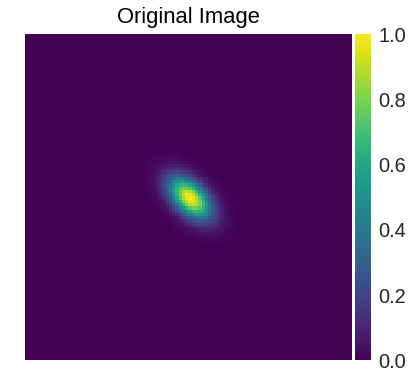

In [14]:
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( img , cmap='viridis' )
ax.set_title('Original Image', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
plt.tight_layout()
#plt.savefig('imagen_original.pdf', format='pdf')


alpha_test_half = estimation['alpha']/np.sqrt(2*np.pi)
C_test_half = estimation['C']
l_test_half = np.exp(estimation['l_log__'])

print('Initial Conditions:')
print('Number of Basis: %s; Number of Samplings: %s' % (numberOfBasis, numberOfSamplings))
print('Cx,Cy: %s; ' % (C_test_half)),
print('alpha: %s; ' % (alpha_test_half)),
print('l: %s' % l_test_half)


Im_reconstructed = sintheticImage(alpha_test_half,C_test_half[:,1], C_test_half[:,0], l_test_half, 
                                 IMAGE_SIZE_X=IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( Im_reconstructed , cmap='viridis' )
ax.set_title('Reconstructed Image {0}% data\n(proposed method)'.format(np.round(p,2)),**title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
plt.tight_layout()
#plt.savefig('imagen_reconstruction-70.pdf', format='pdf')


fig = plt.figure()
ax = plt.gca()
I_res = (Im_reconstructed*np.max(img)/np.max(Im_reconstructed) -  img)
print(np.min(I_res), np.max(I_res))
im = ax.imshow(I_res , cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Reconstructed Image\n(proposed method)', **title_font)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_reconstruction-70_dif.pdf', format='pdf')


Im_pix_real, Im_pix_imag = matrix_points(U,V[:,0], V[:,1],
                                         IMAGE_SIZE_X= IMAGE_SIZE_X, IMAGE_SIZE_Y=IMAGE_SIZE_Y)
Im_pix_fft = Im_pix_real + 1j*Im_pix_imag
Im_pix = np.fft.ifft2(Im_pix_fft)
fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) , cmap='viridis' )
ax.set_title('Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_dirty-70.pdf', format='pdf')

fig = plt.figure()
ax = plt.gca()
im = ax.imshow( np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) - img, cmap='viridis' , clim=(-0.0552899332572, 0.12))
ax.set_title('Residual Dirty Image', **title_font)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')

plt.tight_layout()
#plt.savefig('imagen_dirty-70-dif.pdf', format='pdf')

In [ ]:
print(np.sum((Im_reconstructed*np.max(img)/np.max(Im_reconstructed) -  img)**2) )

In [ ]:
print(np.sum((np.max(img)*np.abs(Im_pix)/np.max(np.abs(Im_pix)) -  img)**2) )